# Dataset 1 Notebook: for analyzing 'EpiOnly_20180710'

## Import Necessary Packages & Read in Data

In [1]:
#Basic Packages
import os
import random
import copy
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None) # display all the columns
import scipy.stats as scs
from scipy.stats import randint
import warnings
warnings.filterwarnings('ignore')

#Visualization Packages:
%matplotlib inline   
import matplotlib.pyplot as plt

#Import Progress bar
from tqdm import tnrange, tqdm_notebook

#Imputation Packages:
from fancyimpute import KNN

#Scikit-Learn Packages:
from sklearn.feature_selection import mutual_info_classif
from skrebate import MultiSURF
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn import datasets

from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

import xgboost as xgb

# Jupyter Notebook Hack: This code ensures that the results of multiple commands within a given cell are all displayed, rather than just the last. 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#Set a random seed for the notebook so that individual runs of the notebook yield the same results
randSeed = 42 #changing this value will potentially change the models and results due to stochastic elements of the pipeline. 
np.random.seed(randSeed)

Using TensorFlow backend.
C:\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


## Specify dataset specific paths/names
This should be the only section/cell in this notebook that is customized to the specific dataset. It may be necessary to change the names and paths to point this notebook to the 

In [2]:
#unique dataset name (target data for this analysis)
data_name = 'Epi_DietAdj_Matched_20180710_Clean'

#path to where original data and pre-CV partitioned datasets are stored
data_path = 'C:/home/work/research_collab/Lynch_Bias_ML_Pancreatic/Datasets/Final Data/'

#path to where this notebooks output files will be saved
out_path =  'C:/home/work/research_collab/Lynch_Bias_ML_Pancreatic/Final Materials/results/notebook_output/' 

#path wehere
multisurf_path = 'C:/home/work/research_collab/Lynch_Bias_ML_Pancreatic/Final Materials/results/cluster/multisurf/'

orig_data = data_path+data_name+'.txt'
print(orig_data)

cv_path = data_path+'CV/'
cv_type = 'CV_M'
cv_data = cv_path+data_name+'_InstLab_'+cv_type+'_'
multisurf_name = 'MultiSURF_'+data_name+'_'+cv_type+'_'

cv = 10
number_of_algorithms = 7 #logisticregression, decisiontree, randomforest, ann, xgboost, svm, naivebayes,- lcs will be added externally


C:/home/work/research_collab/Lynch_Bias_ML_Pancreatic/Datasets/Final Data/Epi_DietAdj_Matched_20180710_Clean.txt


## Load Original Dataset

In [3]:
td = pd.read_csv(orig_data, na_values='NA', sep = "\t") #Data loaded so that blank excell cells are 'NA'
td.shape #Reports the number of (rows,columns)

(980, 39)

In [4]:
num_instances = td.shape[0]
print('Dataset contains '+str(num_instances)+' instances.')
num_features = td.shape[1] - 1
print('Dataset contains '+str(num_features)+' features plus 1 class/outcome.')

Dataset contains 980 instances.
Dataset contains 38 features plus 1 class/outcome.


In [5]:
#Specify outcome variable name
outcome_name = 'panc_type01'

# Exploratory Analysis

In the first section of this notebook, we will read in the data, which has been pre-partitioned into 10 testing and training cross validation sets. We will then conduct various methods of data exploration in order to "get to know" our data for things like dimensions, attributes, statistical features, data imbalance, and missingness.

In [6]:
td.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 980 entries, 0 to 979
Data columns (total 39 columns):
panc_type01            980 non-null int64
cig_stat               980 non-null int64
cig_stop               525 non-null float64
cig_years              967 non-null float64
pack_years             966 non-null float64
total_alcadj           959 non-null float64
total_fatadj           959 non-null float64
tot_Kcal               959 non-null float64
totalcarbadj           959 non-null float64
total_proteinadj       959 non-null float64
totalfolate_NDSRadj    959 non-null float64
total_GlyIndex         959 non-null float64
total_GlyLoad          959 non-null float64
totalcholadj           959 non-null float64
Totalredmeatadj        959 non-null float64
totalCALCIUMadj        959 non-null float64
bmi_curc               973 non-null float64
bmi_curr               973 non-null float64
diabetes_f             977 non-null float64
panc_fh                976 non-null float64
fh_cancer          

In [7]:
#Examine the number of unique values for each variable/feature. Note that missing values are not being include as unique values. 
unique_count = td.nunique()
unique_count

panc_type01              2
cig_stat                 3
cig_stop                53
cig_years               61
pack_years             149
total_alcadj           791
total_fatadj           959
tot_Kcal               959
totalcarbadj           959
total_proteinadj       959
totalfolate_NDSRadj    959
total_GlyIndex         959
total_GlyLoad          958
totalcholadj           959
Totalredmeatadj        959
totalCALCIUMadj        959
bmi_curc                 4
bmi_curr               579
diabetes_f               2
panc_fh                  3
fh_cancer                2
bmi_20                 370
bmi_50                 434
asp                      2
asppd                    8
ibup                     2
ibuppd                   8
gallblad_f               2
liver_comorbidity        2
age                     20
agelevel                 4
educat                   7
race7                    5
total_Marital            5
occupat                  7
center                  10
rndyear                  8
s

In [8]:
#Evaluate missingness and data availability
print("Missing Value Counts")
missing_count = td.isnull().sum()
missing_count

Missing Value Counts


panc_type01              0
cig_stat                 0
cig_stop               455
cig_years               13
pack_years              14
total_alcadj            21
total_fatadj            21
tot_Kcal                21
totalcarbadj            21
total_proteinadj        21
totalfolate_NDSRadj     21
total_GlyIndex          21
total_GlyLoad           21
totalcholadj            21
Totalredmeatadj         21
totalCALCIUMadj         21
bmi_curc                 7
bmi_curr                 7
diabetes_f               3
panc_fh                  4
fh_cancer                1
bmi_20                  11
bmi_50                   4
asp                      3
asppd                    2
ibup                     3
ibuppd                   6
gallblad_f               3
liver_comorbidity        3
age                      0
agelevel                 0
educat                   1
race7                    0
total_Marital            0
occupat                  2
center                   0
rndyear                  0
s

### Assess Class imbalance


Counts of each class
0    652
1    328
Name: panc_type01, dtype: int64


Text(0, 0.5, 'Count')

Text(0.5, 1.0, 'Class Counts (Checking for Imbalance)')

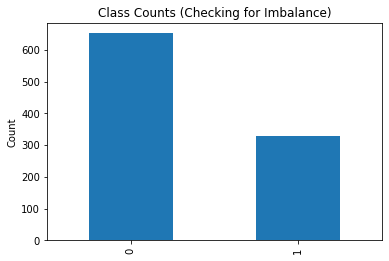

In [9]:
print("Counts of each class")
print(td[outcome_name].value_counts())
td[outcome_name].value_counts().plot(kind='bar')
plt.ylabel('Count')
plt.title('Class Counts (Checking for Imbalance)')

## Load CV partition datasets

In [10]:
#create lists to hold training and testing set dataframes.
trainList = []
testList = []
for i in range(cv):
    #Load training partition
    trainset_name = cv_data+str(i)+'_Train.txt'
    trainSet = pd.read_csv(trainset_name, na_values='NA', sep = "\t")
    trainList.append(trainSet)
    
    #Load testing partition
    testset_name = cv_data+str(i)+'_Test.txt'
    testSet = pd.read_csv(testset_name, na_values='NA', sep = "\t")
    testList.append(testSet)
    
print(len(trainList))
print(len(testList))

10
10


In [11]:
#Confirm case/control counts when merging one training and testing dataset
classesTrain = trainList[0].apply(lambda x: True if x['panc_type01'] == 1 else False , axis=1)
casesTrain = len(classesTrain[classesTrain == True].index)
controlsTrain = len(classesTrain[classesTrain == False].index)

classesTest = testList[0].apply(lambda x: True if x['panc_type01'] == 1 else False , axis=1)
casesTest = len(classesTest[classesTest == True].index)
controlsTest = len(classesTest[classesTest == False].index)

print(casesTrain+casesTest)
print(controlsTrain+controlsTest)

328
652


In [12]:
#Confirm training and testing set dimensions
print("Training Set Dimensions: " + str(trainList[0].shape))
print("Testing Set Dimensions: " + str(testList[0].shape))

Training Set Dimensions: (877, 40)
Testing Set Dimensions: (103, 40)


## Partition data cleaning

In [13]:
# Drop 'plco_id' feature from all training and test sets
for i in range(10):
    trainList[i] = trainList[i].drop(['plco_id'] , axis = 1)
    testList[i] = testList[i].drop(['plco_id'] , axis = 1)

In [14]:
trainColumnNames = list(trainList[0])
testColumnNames = list(testList[0])

# As we can see, 'plco_id' is no longer a column name for any of the sets
print(trainColumnNames)
print(testColumnNames)

ordered_feature_names = copy.deepcopy(trainColumnNames)
ordered_feature_names.remove(outcome_name)
ordered_feature_names

['panc_type01', 'cig_stat', 'cig_stop', 'cig_years', 'pack_years', 'total_alcadj', 'total_fatadj', 'tot_Kcal', 'totalcarbadj', 'total_proteinadj', 'totalfolate_NDSRadj', 'total_GlyIndex', 'total_GlyLoad', 'totalcholadj', 'Totalredmeatadj', 'totalCALCIUMadj', 'bmi_curc', 'bmi_curr', 'diabetes_f', 'panc_fh', 'fh_cancer', 'bmi_20', 'bmi_50', 'asp', 'asppd', 'ibup', 'ibuppd', 'gallblad_f', 'liver_comorbidity', 'age', 'agelevel', 'educat', 'race7', 'total_Marital', 'occupat', 'center', 'rndyear', 'sex', 'shared_cell']
['panc_type01', 'cig_stat', 'cig_stop', 'cig_years', 'pack_years', 'total_alcadj', 'total_fatadj', 'tot_Kcal', 'totalcarbadj', 'total_proteinadj', 'totalfolate_NDSRadj', 'total_GlyIndex', 'total_GlyLoad', 'totalcholadj', 'Totalredmeatadj', 'totalCALCIUMadj', 'bmi_curc', 'bmi_curr', 'diabetes_f', 'panc_fh', 'fh_cancer', 'bmi_20', 'bmi_50', 'asp', 'asppd', 'ibup', 'ibuppd', 'gallblad_f', 'liver_comorbidity', 'age', 'agelevel', 'educat', 'race7', 'total_Marital', 'occupat', 'cent

['cig_stat',
 'cig_stop',
 'cig_years',
 'pack_years',
 'total_alcadj',
 'total_fatadj',
 'tot_Kcal',
 'totalcarbadj',
 'total_proteinadj',
 'totalfolate_NDSRadj',
 'total_GlyIndex',
 'total_GlyLoad',
 'totalcholadj',
 'Totalredmeatadj',
 'totalCALCIUMadj',
 'bmi_curc',
 'bmi_curr',
 'diabetes_f',
 'panc_fh',
 'fh_cancer',
 'bmi_20',
 'bmi_50',
 'asp',
 'asppd',
 'ibup',
 'ibuppd',
 'gallblad_f',
 'liver_comorbidity',
 'age',
 'agelevel',
 'educat',
 'race7',
 'total_Marital',
 'occupat',
 'center',
 'rndyear',
 'sex',
 'shared_cell']

### Impute missing values

In [15]:
# Convert each of the datasets into matrices to prepare for imputation
for i in range(10):
    trainList[i] = trainList[i].as_matrix()
    testList[i] = testList[i].as_matrix()
trainList[0].shape
testList[0].shape

(877, 39)

(103, 39)

In [16]:
# Impute missing data using K-Nearest Neighbors imputation algorithm
for i in range(10):
    trainList[i] = pd.DataFrame(KNN(3).fit_transform(trainList[i]))
    trainList[i].columns = trainColumnNames
    
    testList[i] = pd.DataFrame(KNN(3).fit_transform(testList[i]))
    testList[i].columns = testColumnNames
trainList[0].shape
testList[0].shape

Imputing row 1/877 with 0 missing, elapsed time: 0.292
Imputing row 101/877 with 1 missing, elapsed time: 0.298
Imputing row 201/877 with 3 missing, elapsed time: 0.304
Imputing row 301/877 with 1 missing, elapsed time: 0.308
Imputing row 401/877 with 1 missing, elapsed time: 0.313
Imputing row 501/877 with 1 missing, elapsed time: 0.316
Imputing row 601/877 with 2 missing, elapsed time: 0.322
Imputing row 701/877 with 0 missing, elapsed time: 0.327
Imputing row 801/877 with 0 missing, elapsed time: 0.334
Imputing row 1/103 with 1 missing, elapsed time: 0.013
Imputing row 101/103 with 0 missing, elapsed time: 0.017
Imputing row 1/881 with 1 missing, elapsed time: 0.268
Imputing row 101/881 with 0 missing, elapsed time: 0.272
Imputing row 201/881 with 0 missing, elapsed time: 0.277
Imputing row 301/881 with 0 missing, elapsed time: 0.281
Imputing row 401/881 with 0 missing, elapsed time: 0.286
Imputing row 501/881 with 1 missing, elapsed time: 0.290
Imputing row 601/881 with 0 missing, 

(877, 39)

(103, 39)

### Format data for Scikit learn (separate features from outcome)

In [17]:
# Separate data into training and test features and outcomes
xTrainList = []
yTrainList = []
xTestList = []
yTestList = []

for i in range(10):
    xTrainList.append(trainList[i].iloc[:, 1:].values)
    yTrainList.append(trainList[i].iloc[:, 0].values)
    
    xTestList.append(testList[i].iloc[:, 1:].values)
    yTestList.append(testList[i].iloc[:, 0].values)


## Pipeline Design Strategy
- let's break this pipeline up by ML method so we run through and collect results from FS to Modeling for all CVs for just one method at a time. Create a feature selection def() to call in each. 
- each run will output saved stats and FI results (on a per Modeler basis)
- Then at the end we will collect all results to generate feature importance figures and summaries

# Feature Selection/Weighting

In this section, we will demonstrate various feature processing methods in order to determine the importance/necessity of each of the features that describe the datasets.
- for target training set we will run each method and save Feature importance scores
- then we will examine the union of the two sets to determine which features will be preserved (report counts)
- no need to visualize all these results here since they are on a per-training set basis

In [18]:
def feature_selection(xTrain, yTrain, cv_count):
    
    #Run mutual information algorithm
    mi_results = mutual_info_classif(xTrain, yTrain, random_state=randSeed)
    print(mi_results)
    
    #Run multisurf
    filename = multisurf_path+multisurf_name+str(cv_count)+'_Train.txt'

    #*********************************************************************    
    multisurf_results = []
    
    try:
        fileObject = open(filename, 'r')  # opens each datafile to read.
        #Create Dictionary of scores
        scoreDict = {}
        counter = 0
        for line in fileObject:
            if counter < 3: #ignore the first three rows (Relief-file format)
                pass
            else:
                tempList = line.strip().split('\t')
                scoreDict[tempList[0]] = float(tempList[1]) #all attributes and corresponding EK scores are hashed in a dictionary
            counter += 1

        #Reorganize scores in original feature order
        for i in ordered_feature_names:
            multisurf_results.append(scoreDict[i])

    except:
        print(filename)
        print("Data-set Not Found! Running MultiSURF locally.")

        clf = MultiSURF().fit(xTrain, yTrain)
        multisurf_results = clf.feature_importances_

    print(multisurf_results)
    #*********************************************************************  

    #Get names of features with values over 0
    trainFeatureNames = copy.deepcopy(trainColumnNames)
    trainFeatureNames.remove(outcome_name)

    mi_names = []
    j=0
    for i in mi_results:
        if i > 0.0:
            mi_names.append(trainFeatureNames[j])
        j+=1 

    multisurf_names = []
    j=0
    for i in multisurf_results:
        if i > 0.0:
            multisurf_names.append(trainFeatureNames[j])
        j+=1 

    #Union approach to selecting features to be passed on for modeling
    selected_feature_names = []
    for each in trainFeatureNames:
        if each in multisurf_names or each in mi_names:
            selected_feature_names.append(each)

    print(selected_feature_names)

    #Make list of column indexes corresponding to this union of names
    selected_indexes = []
    for i in selected_feature_names:
        selected_indexes.append(trainFeatureNames.index(i))
    print(selected_indexes)
    print(len(selected_indexes))

    return selected_feature_names, selected_indexes

## Run Feature selection for all CV partitions and create new Train/test feature value sets

In [19]:
#Go through each CV partition, run FS and create a new set of Train/test sets to be used by all methods. 
selected_feature_list =[]
selected_index_list = []

xTrainListFS = []
xTestListFS = []

for i in tqdm_notebook(range(cv), desc='1st loop'):
    #Run feature selection
    selected_feature_names, selected_indexes = feature_selection(xTrainList[i],yTrainList[i], i)
    
    #Store feature sets from each CV
    selected_feature_list.append(selected_feature_names)
    selected_index_list.append(selected_indexes)
    
    #Create training and testing data subsets (only selected features)
    xTrainFS = pd.DataFrame(xTrainList[i])
    xTrainListFS.append(xTrainFS.iloc[: , selected_indexes].values)

    xTestFS = pd.DataFrame(xTestList[i])
    xTestListFS.append(xTestFS.iloc[: , selected_indexes].values)

[0.0522565  0.00982393 0.03833302 0.01736091 0.00952001 0.
 0.00100086 0.025469   0.00551444 0.         0.         0.
 0.         0.03054029 0.00552748 0.         0.00274989 0.
 0.         0.00605202 0.         0.00345925 0.01432705 0.03472085
 0.         0.         0.         0.01810412 0.0009793  0.02758029
 0.00997269 0.         0.         0.01583925 0.01259733 0.
 0.         0.        ]
[0.012460748698, 0.0170813273329, 0.014232696572, 0.016644061547, 0.0153276201483, 0.00780237642387, -0.00169869060555, 0.0107358330754, 0.00134599289702, 0.00532590248307, 0.00638352145613, 0.00256871477303, -0.00238967543503, 0.00349804334036, 0.00192708385684, -0.00030748720401, 0.00335287517875, 0.00734785053468, 0.000510114958678, -0.00293726647699, 0.00263032235415, 0.00257381044469, -0.00761266606257, -0.00654068119897, -0.000929287933994, -0.00223064527701, 0.00175379101557, -0.00233812337822, -0.00468802074071, -0.00782143577557, 0.00317540101538, -0.000409197789569, -0.0031285854088, -0.00

 0.000647   0.        ]
[0.00761204730945, 0.0119782898688, 0.00862573531269, 0.00881804476612, 0.0174338775406, 0.00903447303553, -0.00243230386381, 0.00999776735285, -0.00121771438792, 0.00482094402196, 0.00409827876498, 0.00220579221791, -0.002682045779, 0.000779533866962, 0.00124328255034, -0.000211290606514, 0.00335354460823, 0.0114393090786, -0.000274230509693, -0.00282067716275, 0.00360410403249, 0.00138124803984, -0.00557657214914, -0.00507546376093, -0.000382894706493, -0.000691331412592, -0.00200135153301, -0.00196848334792, -0.00481733183404, -0.00600694285162, 0.00632794610888, 0.000344221096137, -0.00268373462476, -0.00265733599457, -0.00366116721047, -0.00621508710485, -0.00488518835079, -0.0067214234965]
['cig_stat', 'cig_stop', 'cig_years', 'pack_years', 'total_alcadj', 'total_fatadj', 'tot_Kcal', 'totalcarbadj', 'total_proteinadj', 'totalfolate_NDSRadj', 'total_GlyIndex', 'total_GlyLoad', 'Totalredmeatadj', 'totalCALCIUMadj', 'bmi_curc', 'bmi_curr', 'diabetes_f', 'bmi_

## Function to save performance results for machine learner.

In [20]:
def save_performance(algorithm, tp_tmp,tn_tmp,fp_tmp,fn_tmp,acc_tmp,bacc_tmp,rec_tmp,spec_tmp,prec_tmp,f1_tmp):
    
    results = {'TP':tp_tmp, 'TN':tn_tmp, 'FP':fp_tmp, 'FN':fn_tmp, 'Accuracy':acc_tmp, 'Balanced Accuracy':bacc_tmp, 
              'Recall':rec_tmp, 'Specificity':spec_tmp, 'Precision':prec_tmp, 'F1_Score':f1_tmp}

    dr = pd.DataFrame(results)
    
    filepath = out_path+data_name+'_'+algorithm+'_metrics.csv'
    dr.to_csv(filepath, header=True, index=False)  

In [21]:
def save_FI(FI_all):
    
    dr = pd.DataFrame(FI_all)
    filepath = out_path+data_name+'_'+algorithm+'_FI.csv'
    dr.to_csv(filepath, header=ordered_feature_names, index=False)  


## Logistic Regression Modeling

In [22]:
algorithm = 'logistic_regression'

#Define hyperparameters and associated values to be explored in grid search

#param_grid = {"penalty": ['l2'], "max_iter": [100], "C": [1.0]} #Default hyperparameters for local testing
param_grid = {"penalty": ['l1', 'l2'], "max_iter": [100, 1000], "C": [0.001, 0.01, 0.1, 1.0, 10, 100, 1000]}

tp_tmp = []
tn_tmp = []
fp_tmp = []
fn_tmp = []
acc_tmp = []
bacc_tmp = []
rec_tmp = [] #aka sensitivity
spec_tmp = []
prec_tmp = []
f1_tmp = []

FI_temp = [0]*num_features
FI_all = []
print(len(FI_temp))

for i in tqdm_notebook(range(cv), desc='1st loop'):

    #t_xTrainData = xTrainList[i]
    #t_xTestData = xTestList[i]
    t_xTrainData = xTrainListFS[i]
    t_xTestData = xTestListFS[i]
    
    #Run Hyperparameter sweep
    clf = LogisticRegression(random_state = randSeed)
    search = GridSearchCV(estimator=clf, n_jobs = -1, param_grid=param_grid, scoring='balanced_accuracy')
    search.fit(t_xTrainData, yTrainList[i])
    #print(search.best_score_)
    print(search.best_params_)
    
    #Train model using 'best' hyperparameters - Uses default 3-fold internal CV (training/validation splits)
    clf = LogisticRegression(random_state = randSeed, n_jobs = -1, penalty=search.best_params_['penalty'],max_iter=search.best_params_['max_iter'],C=search.best_params_['C'])
    model = clf.fit(t_xTrainData, yTrainList[i])
    
    #Prediction evaluation
    yPred = clf.predict(t_xTestData)
    
    #calculate and store evaluation metrics
    tn, fp, fn, tp = confusion_matrix(yTestList[i], yPred).ravel()
    tp_tmp.append(tp)
    tn_tmp.append(tn)
    fp_tmp.append(fp)
    fn_tmp.append(fn)
    
    acc_tmp.append(accuracy_score(yTestList[i], yPred))
    bacc_tmp.append(balanced_accuracy_score(yTestList[i], yPred))
    rec_tmp.append(recall_score(yTestList[i], yPred)) #aka sensitivity
    prec_tmp.append(precision_score(yTestList[i], yPred))
    f1_tmp.append(f1_score(yTestList[i], yPred))
    
    #calculate specificity
    if tn == 0 and fp == 0:
        spec = 0
    else:
        spec = tn/float(tn+fp)
    spec_tmp.append(spec)
        
    #obtain and store feature importance scores
    print("\n---Feature Importances---\n")
    LRImp = np.exp(clf.coef_[0])
    print(LRImp)
    print(len(LRImp))

    
    #sum feature importance scores across CVs
    score_count = 0
    tempList = []
    for j in range(0,num_features):
        if j in selected_index_list[i]:
            FI_temp[j] += LRImp[score_count]
            tempList.append(LRImp[score_count])
            score_count += 1

        else:
            tempList.append(0)
            
    FI_all.append(tempList)
    
    #for k, v in sorted(zip(map(lambda x: round(x, 4), LRImp), trainList[0].iloc[:, 1:].columns), reverse=True):
    #    print (v + ": " + str(k))

print(FI_temp)

#Calculate average feature importance scores
for i in range(0,len(FI_temp)):
    FI_temp[i] = FI_temp[i]/float(cv)

print('---------------------------------------------------------')
print(FI_temp)
print(len(FI_temp))
print('---------------------------------------------------------')

#Save performance metrics to file
save_performance(algorithm, tp_tmp,tn_tmp,fp_tmp,fn_tmp,acc_tmp,bacc_tmp,rec_tmp,spec_tmp,prec_tmp,f1_tmp)

#save feature importance scores to file
save_FI(FI_all)

#-------------------------------------------------------------------
print("Avg. Model Balanced Accuracy = " + str(np.mean(bacc_tmp)) +
     " (std. dev. = " + str(np.std(bacc_tmp)) + ")")    
print("Avg. Model Accuracy = " + str(np.mean(acc_tmp)) +
      " (std. dev. = " + str(np.std(acc_tmp)) + ")")
print("Avg. Model Specificity = " + str(np.mean(spec_tmp)) +
     " (std. dev. = " + str(np.std(spec_tmp)) + ")")
print("Avg. Model Recall = " + str(np.mean(rec_tmp)) +
     " (std. dev. = " + str(np.std(rec_tmp)) + ")")
print("Avg. Model Precision = " + str(np.mean(prec_tmp)) +
      " (std. dev. = " + str(np.std(prec_tmp)) + ")")
print("Avg. Model F1-Score = " + str(np.mean(f1_tmp)) +
      " (std. dev. = " + str(np.std(f1_tmp)) + ")")
print("Avg. Model True Positives = " + str(np.mean(tp_tmp)) +
      " (std. dev. = " + str(np.std(tp_tmp)) + ")")
print("Avg. Model True Negatives = " + str(np.mean(tn_tmp)) +
      " (std. dev. = " + str(np.std(tn_tmp)) + ")")
print("Avg. Model False Positives = " + str(np.mean(fp_tmp)) +
      " (std. dev. = " + str(np.std(fp_tmp)) + ")")
print("Avg. Model False Negatives = " + str(np.mean(fn_tmp)) +
      " (std. dev. = " + str(np.std(fn_tmp)) + ")")
    

38


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=42, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1.0, 10, 100, 1000],
                         'max_iter': [100, 1000], 'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='balanced_accuracy', verbose=0)

{'C': 1000, 'max_iter': 100, 'penalty': 'l1'}

---Feature Importances---

[8.36183399e-01 9.92815119e-01 1.01955835e+00 1.00108516e+00
 2.50429461e+07 8.50458315e-01 9.99443690e-01 5.04634349e-05
 8.80071111e-06 3.44880670e+00 1.00391397e+00 1.00829055e+00
 1.06178577e+02 1.48282208e+00 1.02589153e+00 1.42327408e+00
 9.48829693e-01 1.16679364e+00 1.08979580e+00 9.39572838e-01
 1.02734271e+00 9.56165933e-01 1.32374873e+00 9.09832196e-01
 9.96508368e-01 9.93779745e-01 1.02913473e+00 1.09507901e+00
 9.95983823e-01]
29


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=42, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1.0, 10, 100, 1000],
                         'max_iter': [100, 1000], 'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='balanced_accuracy', verbose=0)

{'C': 100, 'max_iter': 100, 'penalty': 'l1'}

---Feature Importances---

[8.41872429e-01 9.90484615e-01 1.01455336e+00 1.00246791e+00
 1.96878377e+08 1.00000000e+00 9.99426984e-01 4.51435319e-03
 6.84619415e-04 3.09928871e+00 9.95782641e-01 1.00822249e+00
 2.46747333e+01 1.22567242e+00 1.12607665e+00 9.91448125e-01
 1.56776672e+00 9.49156093e-01 1.30415116e+00 1.10547840e+00
 9.53492974e-01 1.09971575e+00 9.69140879e-01 9.42913767e-01
 1.31211602e+00 8.44469937e-01 1.00103989e+00 9.98651951e-01
 9.99618474e-01 9.84589610e-01 9.72925606e-01 1.12933615e+00]
32


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=42, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1.0, 10, 100, 1000],
                         'max_iter': [100, 1000], 'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='balanced_accuracy', verbose=0)

{'C': 1000, 'max_iter': 100, 'penalty': 'l1'}

---Feature Importances---

[7.96932233e-01 9.97849323e-01 1.01763881e+00 1.00399327e+00
 9.63941151e+09 2.83209512e+05 9.99414954e-01 2.18005069e-03
 4.27927909e-05 3.69708363e+00 1.00356446e+00 1.00789996e+00
 2.73084855e+01 1.28356796e+00 1.25501789e+00 9.89328890e-01
 1.50892569e+00 9.76734513e-01 1.09924844e+00 9.47431586e-01
 9.88386652e-01 9.40281529e-01 1.15876167e+00 9.07837997e-01
 1.00772416e+00 1.03585795e+00 1.01469329e+00 1.00394800e+00
 9.99298949e-01 1.18641534e+00]
30


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=42, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1.0, 10, 100, 1000],
                         'max_iter': [100, 1000], 'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='balanced_accuracy', verbose=0)

{'C': 0.1, 'max_iter': 100, 'penalty': 'l2'}

---Feature Importances---

[0.85394924 0.98373761 1.0115878  1.00442854 1.01066043 0.99769605
 0.99978713 0.97688169 0.99310995 0.96749112 0.97117747 1.00151964
 1.0020511  1.05322718 0.97964481 0.99945117 1.2847265  0.96292425
 1.13894784 1.08018692 0.97417249 0.95579258 0.90097897 1.02796853
 1.20543271 1.02870808 0.92943986 1.11179739]
28


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=42, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1.0, 10, 100, 1000],
                         'max_iter': [100, 1000], 'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='balanced_accuracy', verbose=0)

{'C': 0.1, 'max_iter': 100, 'penalty': 'l2'}

---Feature Importances---

[0.84898797 0.99506695 1.02010621 1.00184893 1.0054975  0.99843604
 0.99987084 0.99494893 0.99880867 1.00309888 1.00878977 1.0010451
 1.00243146 1.12899498 1.0044611  1.27195042 0.96923774 1.04168653
 1.1171254  0.95409081 0.90841638 1.14917665 1.02553429 1.01729788
 1.02001317 1.07811559 0.99849029]
27


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=42, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1.0, 10, 100, 1000],
                         'max_iter': [100, 1000], 'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='balanced_accuracy', verbose=0)

{'C': 0.01, 'max_iter': 100, 'penalty': 'l2'}

---Feature Importances---

[0.9322234  0.98476472 1.00979037 1.00236557 1.00184945 0.99950279
 0.99994037 0.99847471 0.99948071 1.00133668 1.0125958  0.99951822
 1.0002358  1.00590525 1.02670216 1.01780762 1.0575172  1.1066377
 0.94922085 0.98880251 1.03156597 1.02758859 1.03674217 1.00898603
 0.99864368 1.03733781]
26


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=42, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1.0, 10, 100, 1000],
                         'max_iter': [100, 1000], 'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='balanced_accuracy', verbose=0)

{'C': 1000, 'max_iter': 100, 'penalty': 'l1'}

---Feature Importances---

[8.39850964e-01 9.90465955e-01 1.01746057e+00 1.00065562e+00
 3.97267710e+10 1.24368553e+05 9.99372302e-01 1.22207536e-03
 1.84682903e-04 3.12556662e+00 9.98969285e-01 1.00889884e+00
 4.36389549e+01 1.44444859e+00 1.27315744e+00 9.76112131e-01
 1.58869664e+00 9.68611846e-01 1.06924993e+00 9.81044714e-01
 9.74307683e-01 9.03741945e-01 1.01796303e+00 1.21644329e+00
 8.10148765e-01 9.72127328e-01 1.02350857e+00 1.05944997e+00
 1.12820297e+00 1.08433333e+00]
30


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=42, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1.0, 10, 100, 1000],
                         'max_iter': [100, 1000], 'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='balanced_accuracy', verbose=0)

{'C': 0.1, 'max_iter': 100, 'penalty': 'l2'}

---Feature Importances---

[0.85236076 0.98849071 1.01585356 1.00358758 1.01194192 0.9978154
 0.99968723 0.96960644 0.9948379  0.97518632 0.98196949 1.00370051
 1.00763196 1.02806141 1.20604633 0.98334311 1.4300182  0.9375483
 1.14207601 1.06983069 0.94457142 1.04286043 1.01028881 1.10402189
 0.9619377  1.01377898 1.08559194 1.04488434]
28


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=42, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1.0, 10, 100, 1000],
                         'max_iter': [100, 1000], 'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='balanced_accuracy', verbose=0)

{'C': 1.0, 'max_iter': 100, 'penalty': 'l1'}

---Feature Importances---

[0.80287876 0.99280896 1.02000006 1.00200885 1.         1.
 0.99979089 1.         1.         1.         0.97794399 1.00258522
 1.         1.         1.14095536 0.98694231 1.53843715 0.96932028
 1.08508188 1.08190519 0.94564151 0.98287926 0.97870513 1.29383011
 1.01862543 0.95882296 1.         1.10360157]
28


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=42, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1.0, 10, 100, 1000],
                         'max_iter': [100, 1000], 'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='balanced_accuracy', verbose=0)

{'C': 1.0, 'max_iter': 100, 'penalty': 'l2'}

---Feature Importances---

[0.82818464 0.98949633 1.01405125 1.00335827 1.0250241  0.98882068
 0.99980467 0.95728249 0.98776512 0.9304624  0.98169373 1.00203402
 1.02309142 1.01950271 1.41744648 0.94648006 1.61711286 1.02834704
 1.08785035 0.95938802 0.94402244 0.99835386 1.22575935 0.76975925
 0.9687246  0.97520002 1.09004226 1.17429945]
28

[8.433423799936048, 9.905980289765806, 10.160600350127199, 10.025799698630959, 49588103858.03641, 407585.8980408742, 9.996539070257747, 5.905161197234006, 5.974923239483858, 19.248321069745963, 9.936400601435647, 10.04371454646015, 0, 207.83619241280365, 11.67220258954669, 9.425047132085778, 9.921266042616873, 14.288425466196054, 7.682362712133137, 8.976334023703592, 9.838058881893614, 9.548627222814455, 4.078335277326348, 5.826672979186586, 4.631938652630174, 6.02208186974618, 12.020856379053864, 5.260673569938988, 0.9965083684015256, 6.8641563892357205, 10.157963164944151, 5.127801780560889, 4.946976

## Decision Tree Model

In [23]:
algorithm = 'decision_tree'

#param_grid = {"max_depth": [3], "min_samples_split": [10], "min_samples_leaf": [10], 
#              "criterion": ["gini"]}
param_grid = {"max_depth": [3, 6, None], "min_samples_split": [2,5,10],"min_samples_leaf": [1,5,10], 
              "criterion": ["gini", "entropy"]}

tp_tmp = []
tn_tmp = []
fp_tmp = []
fn_tmp = []
acc_tmp = []
bacc_tmp = []
rec_tmp = [] #aka sensitivity
spec_tmp = []
prec_tmp = []
f1_tmp = []

FI_all = []
FI_temp = [0]*num_features
print(len(FI_temp))

for i in tqdm_notebook(range(cv), desc='1st loop'):

    #t_xTrainData = xTrainList[i]
    #t_xTestData = xTestList[i]
    t_xTrainData = xTrainListFS[i]
    t_xTestData = xTestListFS[i]
    
    #Run Hyperparameter sweep
    clf = tree.DecisionTreeClassifier(random_state = randSeed)
    search = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='balanced_accuracy')
    search.fit(t_xTrainData, yTrainList[i])
    #print(search.best_score_)
    print(search.best_params_)
    
    #Train model using 'best' hyperparameters - Uses default 3-fold internal CV (training/validation splits)
    clf = tree.DecisionTreeClassifier(random_state = randSeed, max_depth=search.best_params_['max_depth'],min_samples_split=search.best_params_['min_samples_split'],min_samples_leaf=search.best_params_['min_samples_leaf'], criterion=search.best_params_['criterion'])
    model = clf.fit(t_xTrainData, yTrainList[i])
    
    #Prediction evaluation
    yPred = clf.predict(t_xTestData)
    
    #calculate and store evaluation metrics
    tn, fp, fn, tp = confusion_matrix(yTestList[i], yPred).ravel()
    tp_tmp.append(tp)
    tn_tmp.append(tn)
    fp_tmp.append(fp)
    fn_tmp.append(fn)
    
    acc_tmp.append(accuracy_score(yTestList[i], yPred))
    bacc_tmp.append(balanced_accuracy_score(yTestList[i], yPred))
    rec_tmp.append(recall_score(yTestList[i], yPred)) #aka sensitivity
    prec_tmp.append(precision_score(yTestList[i], yPred))
    f1_tmp.append(f1_score(yTestList[i], yPred))
    
    #calculate specificity
    if tn == 0 and fp == 0:
        spec = 0
    else:
        spec = tn/float(tn+fp)
    spec_tmp.append(spec)
        
    #obtain and store feature importance scores
    print("\n---Feature Importances---\n")
    DTImp = clf.feature_importances_
    print(DTImp)
    print(len(DTImp))

    #sum feature importance scores across CVs
    score_count = 0
    tempList = []
    for j in range(0,num_features):
        if j in selected_index_list[i]:
            FI_temp[j] += DTImp[score_count]
            tempList.append(DTImp[score_count])
            score_count += 1

        else:
            tempList.append(0)
            
    FI_all.append(tempList)

    #for k, v in sorted(zip(map(lambda x: round(x, 4), DTImp), trainList[0].iloc[:, 1:].columns), reverse=True):
    #    print (v + ": " + str(k))

print(FI_temp)

#Calculate average feature importance scores
for i in range(0,len(FI_temp)):
    FI_temp[i] = FI_temp[i]/float(cv)

print('---------------------------------------------------------')
print(FI_temp)
print(len(FI_temp))
print('---------------------------------------------------------')

#Save performance metrics to file
save_performance(algorithm, tp_tmp,tn_tmp,fp_tmp,fn_tmp,acc_tmp,bacc_tmp,rec_tmp,spec_tmp,prec_tmp,f1_tmp)

#save feature importance scores to file
save_FI(FI_all)

#-------------------------------------------------------------------
print("Avg. Model Balanced Accuracy = " + str(np.mean(bacc_tmp)) +
     " (std. dev. = " + str(np.std(bacc_tmp)) + ")")    
print("Avg. Model Accuracy = " + str(np.mean(acc_tmp)) +
      " (std. dev. = " + str(np.std(acc_tmp)) + ")")
print("Avg. Model Specificity = " + str(np.mean(spec_tmp)) +
     " (std. dev. = " + str(np.std(spec_tmp)) + ")")
print("Avg. Model Recall = " + str(np.mean(rec_tmp)) +
     " (std. dev. = " + str(np.std(rec_tmp)) + ")")
print("Avg. Model Precision = " + str(np.mean(prec_tmp)) +
      " (std. dev. = " + str(np.std(prec_tmp)) + ")")
print("Avg. Model F1-Score = " + str(np.mean(f1_tmp)) +
      " (std. dev. = " + str(np.std(f1_tmp)) + ")")
print("Avg. Model True Positives = " + str(np.mean(tp_tmp)) +
      " (std. dev. = " + str(np.std(tp_tmp)) + ")")
print("Avg. Model True Negatives = " + str(np.mean(tn_tmp)) +
      " (std. dev. = " + str(np.std(tn_tmp)) + ")")
print("Avg. Model False Positives = " + str(np.mean(fp_tmp)) +
      " (std. dev. = " + str(np.std(fp_tmp)) + ")")
print("Avg. Model False Negatives = " + str(np.mean(fn_tmp)) +
      " (std. dev. = " + str(np.std(fn_tmp)) + ")")

38


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=42,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 6, None],
                      

{'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}

---Feature Importances---

[0.         0.50350845 0.         0.         0.         0.
 0.         0.         0.11540624 0.         0.         0.22855674
 0.         0.         0.         0.         0.         0.
 0.09019331 0.         0.         0.         0.         0.
 0.06233526 0.         0.         0.         0.        ]
29


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=42,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 6, None],
                      

{'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 5, 'min_samples_split': 2}

---Feature Importances---

[0.         0.42780745 0.09813949 0.         0.         0.09156418
 0.         0.         0.         0.10638247 0.         0.
 0.         0.         0.         0.11688527 0.         0.
 0.         0.15922114 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
32


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=42,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 6, None],
                      

{'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 1, 'min_samples_split': 10}

---Feature Importances---

[0.         0.18496139 0.         0.         0.17875698 0.
 0.22137334 0.04427379 0.03404504 0.06737456 0.02737005 0.06436308
 0.02194175 0.06932018 0.         0.         0.         0.
 0.08621984 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]
30


C:\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=42,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 6, None],
                      

{'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 10, 'min_samples_split': 2}

---Feature Importances---

[0.         0.40930517 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.19767554
 0.         0.         0.09570944 0.11979362 0.         0.
 0.         0.17751623 0.         0.         0.         0.
 0.         0.         0.         0.        ]
28


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=42,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 6, None],
                      

{'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 1, 'min_samples_split': 2}

---Feature Importances---

[0.         0.12850922 0.04846232 0.03647316 0.         0.03441936
 0.11864516 0.05141711 0.04322556 0.         0.03063615 0.11832291
 0.02970758 0.09327907 0.07229558 0.04890694 0.         0.
 0.08113429 0.         0.         0.         0.06456558 0.
 0.         0.         0.        ]
27


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=42,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 6, None],
                      

{'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 5, 'min_samples_split': 2}

---Feature Importances---

[0.         0.39499302 0.         0.         0.         0.
 0.         0.         0.06526997 0.         0.         0.31564133
 0.         0.09683631 0.         0.         0.         0.12725937
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
26


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=42,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 6, None],
                      

{'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 1, 'min_samples_split': 10}

---Feature Importances---

[0.         0.21643902 0.03683827 0.0424499  0.03414877 0.08976836
 0.         0.         0.04252956 0.03540414 0.         0.13930366
 0.08300452 0.11261129 0.         0.04528205 0.         0.
 0.         0.         0.         0.         0.         0.
 0.02306019 0.04851417 0.         0.         0.05064609 0.        ]
30


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=42,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 6, None],
                      

{'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 10, 'min_samples_split': 2}

---Feature Importances---

[0.         0.47446394 0.         0.         0.05677461 0.
 0.14058195 0.         0.         0.         0.         0.17880394
 0.         0.07960378 0.         0.         0.         0.
 0.         0.         0.06977178 0.         0.         0.
 0.         0.         0.         0.        ]
28


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=42,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 6, None],
                      

{'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 10, 'min_samples_split': 2}

---Feature Importances---

[0.         0.38753743 0.         0.         0.         0.
 0.         0.07931331 0.         0.         0.         0.18904036
 0.         0.2313335  0.         0.         0.         0.
 0.         0.1127754  0.         0.         0.         0.
 0.         0.         0.         0.        ]
28


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=42,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 6, None],
                      

{'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 1, 'min_samples_split': 10}

---Feature Importances---

[0.         0.16307615 0.04368548 0.03608482 0.04042833 0.09111807
 0.14288774 0.03838033 0.         0.03072935 0.13069144 0.06453733
 0.02188508 0.0352652  0.03175701 0.04291592 0.         0.
 0.08655776 0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]
28

[0.0, 3.2906012472884507, 0.2271255557979188, 0.11500788139230281, 0.31010868723188906, 0.3068699606383862, 0.6234881995146337, 0.2133845481976865, 0.3004763744255801, 0.23989051395024236, 0.18869764442532716, 1.4962448853926422, 0, 0.15653892642197875, 0.7182493363684324, 0.12746645260738299, 0.3971724460946998, 0.048906940928720125, 0.0, 0.0, 0.9208773283391891, 0.0697717780586033, 0.0, 0.0, 0.0, 0.0, 0.0, 0.023060188950929438, 0.062335263309272505, 0.0485141691424398, 0.06456557739416552, 0.0, 0.0, 0.05064609412912692, 0.0, 0.0, 0.0, 0]
--------------------------------------

## Random Forest Model

In [24]:
algorithm = 'random_forest'

#param_grid = {"max_depth": [3], "min_samples_split": [10],"min_samples_leaf": [10], 
#              "criterion": ["gini"],"n_estimators": [10], "max_features": ['auto']}
param_grid = {"max_depth": [3, 6, None], "min_samples_split": [2,5,10],"min_samples_leaf": [1,5,10], 
              "criterion": ["gini", "entropy"],"n_estimators": [10,100,1000], "max_features": ['auto', 'log2']}

tp_tmp = []
tn_tmp = []
fp_tmp = []
fn_tmp = []
acc_tmp = []
bacc_tmp = []
rec_tmp = [] #aka sensitivity
spec_tmp = []
prec_tmp = []
f1_tmp = []

FI_all = []
FI_temp = [0]*num_features
print(len(FI_temp))

for i in tqdm_notebook(range(cv), desc='1st loop'):

    #t_xTrainData = xTrainList[i]
    #t_xTestData = xTestList[i]
    t_xTrainData = xTrainListFS[i]
    t_xTestData = xTestListFS[i]
    
    #Run Hyperparameter sweep
    clf = RandomForestClassifier(random_state = randSeed)
    search = GridSearchCV(estimator=clf, n_jobs = -1, param_grid=param_grid, scoring='balanced_accuracy')
    search.fit(t_xTrainData, yTrainList[i])
    #print(search.best_score_)
    print(search.best_params_)
    
    #Train model using 'best' hyperparameters - Uses default 3-fold internal CV (training/validation splits)
    clf = RandomForestClassifier(random_state = randSeed, n_jobs = -1, max_depth=search.best_params_['max_depth'], min_samples_split=search.best_params_['min_samples_split'],min_samples_leaf=search.best_params_['min_samples_leaf'], criterion=search.best_params_['criterion'],n_estimators=search.best_params_['n_estimators'],max_features=search.best_params_['max_features'])
    model = clf.fit(t_xTrainData, yTrainList[i])
    
    #Prediction evaluation
    yPred = clf.predict(t_xTestData)
    
    #calculate and store evaluation metrics
    tn, fp, fn, tp = confusion_matrix(yTestList[i], yPred).ravel()
    tp_tmp.append(tp)
    tn_tmp.append(tn)
    fp_tmp.append(fp)
    fn_tmp.append(fn)
    
    acc_tmp.append(accuracy_score(yTestList[i], yPred))
    bacc_tmp.append(balanced_accuracy_score(yTestList[i], yPred))
    rec_tmp.append(recall_score(yTestList[i], yPred)) #aka sensitivity
    prec_tmp.append(precision_score(yTestList[i], yPred))
    f1_tmp.append(f1_score(yTestList[i], yPred))
    
    #calculate specificity
    if tn == 0 and fp == 0:
        spec = 0
    else:
        spec = tn/float(tn+fp)
    spec_tmp.append(spec)
        
    #obtain and store feature importance scores
    print("\n---Feature Importances---\n")
    RFImp = clf.feature_importances_
    print(RFImp)
    print(len(RFImp))
    
    #sum feature importance scores across CVs
    score_count = 0
    tempList = []
    for j in range(0,num_features):
        if j in selected_index_list[i]:
            FI_temp[j] += RFImp[score_count]
            tempList.append(RFImp[score_count])
            score_count += 1

        else:
            tempList.append(0)
            
    FI_all.append(tempList)

    #for k, v in sorted(zip(map(lambda x: round(x, 4), RFImp), trainList[0].iloc[:, 1:].columns), reverse=True):
    #    print (v + ": " + str(k))

print(FI_temp)

#Calculate average feature importance scores
for i in range(0,len(FI_temp)):
    FI_temp[i] = FI_temp[i]/float(cv)

print('---------------------------------------------------------')
print(FI_temp)
print(len(FI_temp))
print('---------------------------------------------------------')

#Save performance metrics to file
save_performance(algorithm, tp_tmp,tn_tmp,fp_tmp,fn_tmp,acc_tmp,bacc_tmp,rec_tmp,spec_tmp,prec_tmp,f1_tmp)

#save feature importance scores to file
save_FI(FI_all)

#-------------------------------------------------------------------
print("Avg. Model Balanced Accuracy = " + str(np.mean(bacc_tmp)) +
     " (std. dev. = " + str(np.std(bacc_tmp)) + ")")    
print("Avg. Model Accuracy = " + str(np.mean(acc_tmp)) +
      " (std. dev. = " + str(np.std(acc_tmp)) + ")")
print("Avg. Model Specificity = " + str(np.mean(spec_tmp)) +
     " (std. dev. = " + str(np.std(spec_tmp)) + ")")
print("Avg. Model Recall = " + str(np.mean(rec_tmp)) +
     " (std. dev. = " + str(np.std(rec_tmp)) + ")")
print("Avg. Model Precision = " + str(np.mean(prec_tmp)) +
      " (std. dev. = " + str(np.std(prec_tmp)) + ")")
print("Avg. Model F1-Score = " + str(np.mean(f1_tmp)) +
      " (std. dev. = " + str(np.std(f1_tmp)) + ")")
print("Avg. Model True Positives = " + str(np.mean(tp_tmp)) +
      " (std. dev. = " + str(np.std(tp_tmp)) + ")")
print("Avg. Model True Negatives = " + str(np.mean(tn_tmp)) +
      " (std. dev. = " + str(np.std(tn_tmp)) + ")")
print("Avg. Model False Positives = " + str(np.mean(fp_tmp)) +
      " (std. dev. = " + str(np.std(fp_tmp)) + ")")
print("Avg. Model False Negatives = " + str(np.mean(fn_tmp)) +
      " (std. dev. = " + str(np.std(fn_tmp)) + ")")

38


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_sco...se, random_state=42,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'

{'criterion': 'gini', 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 1000}

---Feature Importances---

[0.0076449  0.06589074 0.04362027 0.03835846 0.04683649 0.05172002
 0.05132819 0.05610419 0.05451061 0.05310798 0.05401705 0.05267507
 0.05001631 0.05435578 0.05246056 0.00612673 0.00499228 0.00694658
 0.05532423 0.0489819  0.00644518 0.01760661 0.00563179 0.00325977
 0.03460577 0.01216949 0.02318909 0.01441878 0.02765516]
29


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_sco...se, random_state=42,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'

{'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

---Feature Importances---

[0.00743732 0.06881281 0.03614634 0.03479843 0.04688295 0.05312186
 0.05853698 0.0511889  0.05462543 0.05340543 0.05006008 0.0523548
 0.04850144 0.05339698 0.01224225 0.05353463 0.00600166 0.00446543
 0.01045509 0.057632   0.04788446 0.00752073 0.01929875 0.00783651
 0.00600518 0.00411702 0.0168199  0.02497342 0.00618056 0.01021043
 0.02830991 0.00724232]
32


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_sco...se, random_state=42,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'

{'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}

---Feature Importances---

[0.00584496 0.06746991 0.04386455 0.03425955 0.0482548  0.05420807
 0.05643345 0.06202586 0.05181874 0.05405125 0.05596067 0.06593935
 0.05154686 0.06299694 0.00975021 0.04850331 0.00753924 0.00524399
 0.05489329 0.04931903 0.01847559 0.00441419 0.00574512 0.00269998
 0.01189069 0.02233134 0.00598457 0.01117886 0.0223732  0.00498244]
30


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_sco...se, random_state=42,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'

{'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}

---Feature Importances---

[0.00906288 0.07916409 0.04343792 0.04065249 0.04924185 0.05575781
 0.0563863  0.06353292 0.05387877 0.05455372 0.05725896 0.06155377
 0.04880285 0.05357343 0.01059769 0.04858871 0.00701961 0.00424478
 0.00650239 0.05719938 0.0480047  0.01779723 0.00404926 0.01712698
 0.00654302 0.02050387 0.00865231 0.0163123 ]
28


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_sco...se, random_state=42,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'

{'criterion': 'gini', 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}

---Feature Importances---

[0.0089792  0.07969793 0.03766092 0.03427329 0.05001579 0.05734462
 0.05324966 0.05794158 0.0515301  0.05446607 0.05405764 0.05821258
 0.04769028 0.05915947 0.05230184 0.01007239 0.00581987 0.00546067
 0.06268091 0.05823347 0.00827098 0.00768329 0.02161117 0.0074273
 0.01159799 0.01661165 0.02794935]
27


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_sco...se, random_state=42,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'

{'criterion': 'gini', 'max_depth': 6, 'max_features': 'auto', 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 10}

---Feature Importances---

[0.0025183  0.11931763 0.04587153 0.06628765 0.05065758 0.06706705
 0.0538461  0.04661916 0.04218761 0.03115168 0.05031139 0.0579144
 0.03117557 0.06795943 0.0067349  0.06772974 0.01110578 0.05598368
 0.09388767 0.01352109 0.         0.00152699 0.         0.
 0.01426577 0.00235932]
26


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_sco...se, random_state=42,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'

{'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}

---Feature Importances---

[0.00572906 0.07517171 0.04900609 0.03852084 0.0501691  0.05846493
 0.05669099 0.06211156 0.06204598 0.06093103 0.06018479 0.0601008
 0.05235364 0.06015253 0.01123075 0.05664358 0.00668724 0.00502285
 0.00541203 0.05441773 0.01966571 0.00550297 0.01482946 0.00639253
 0.00340981 0.01309615 0.01847602 0.00647066 0.01594593 0.00516354]
30


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_sco...se, random_state=42,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'

{'criterion': 'gini', 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}

---Feature Importances---

[0.00896893 0.08090904 0.04568613 0.03826951 0.05197326 0.05602136
 0.05289287 0.06314476 0.05397966 0.05493645 0.05693825 0.05976811
 0.04764985 0.05438754 0.01051478 0.05432341 0.00776775 0.00603317
 0.00680778 0.05020304 0.05124879 0.00533953 0.01831347 0.00516348
 0.01322579 0.02286859 0.01725591 0.00540877]
28


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_sco...se, random_state=42,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'

{'criterion': 'gini', 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 10}

---Feature Importances---

[0.00811897 0.08524127 0.04655497 0.03261826 0.0439888  0.04248516
 0.04411077 0.05698933 0.05893465 0.04535121 0.07822046 0.08085429
 0.04839357 0.04932621 0.02046595 0.05801451 0.00275728 0.
 0.01125526 0.05583375 0.05278113 0.02038208 0.01399149 0.00324497
 0.         0.01121498 0.01614392 0.01272675]
28


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_sco...se, random_state=42,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'

{'criterion': 'gini', 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 10}

---Feature Importances---

[0.00688514 0.08816804 0.03300087 0.04160497 0.05056385 0.05444994
 0.06154792 0.07705544 0.04655793 0.04457209 0.05848242 0.05663646
 0.06222582 0.06207368 0.01428687 0.05323336 0.00670361 0.0081996
 0.0547994  0.04071781 0.00581787 0.01355394 0.00805874 0.00067732
 0.01067656 0.02608125 0.00989468 0.00347442]
28

[0.07118967526583697, 0.8098431537999008, 0.4248495888769709, 0.3996434425434428, 0.48858445582253784, 0.5506408138689415, 0.5450232237709909, 0.5967136877380641, 0.530069495482259, 0.5065269164777131, 0.5754917279276404, 0.606009627608425, 0, 0.4883561968032564, 0.5773819860782942, 0.0958234067434827, 0.5453336609717473, 0.07178128937062814, 0.03582238444674384, 0.061039400835769954, 0.5045496721904162, 0.5454766749318383, 0.027576425211257444, 0.11322596018051054, 0.027620798654273467, 0.09133643058492613, 0.054468

In [25]:
def computeImportances(clf,selected_indexes,t_xTrainData,t_xTestData,t_yTrainData,t_yTestData):
    #Reruns the model n times (once for each feature), and evaluates performance change as a standard of feature importance
    print(selected_indexes)
    feature_count = len(selected_indexes)
    print(feature_count)
    FIbAccList = []
    for feature in range(feature_count):
        indexList = []
        indexList.extend(range(0, feature))
        indexList.extend(range(feature + 1, feature_count))
        print(indexList)
        
        #Create temporary training and testing sets
        tempTrain = pd.DataFrame(t_xTrainData)
        FIxTrainList = tempTrain.iloc[:, indexList].values
        
        tempTest = pd.DataFrame(t_xTestData)
        FIxTestList = tempTest.iloc[:, indexList].values
        
        clf.fit(FIxTrainList, t_yTrainData)
        FIyPred = clf.predict(FIxTestList)
        
        FIbAccList.append(balanced_accuracy_score(t_yTestData, FIyPred))
    
    #Lower metric values suggest higher feature importance
    featureImpList = []
    for element in FIbAccList:
        imp = 1 - element
        featureImpList.append(imp)
        
    #for k, v in sorted(zip(map(lambda x: round(x, 4), featureImpList), trainList[0].iloc[:, 1:].columns), reverse=True):
    #    print (v + ": " + str(k))
    
    return featureImpList

## XGBoost Model

In [26]:
algorithm = 'xgboost'

#param_grid = {'min_child_weight': [1],'gamma': [0],'subsample': [1.0],
#              'colsample_bytree': [1.0],'max_depth': [6], 'learning_rate' : [0.3]}

param_grid = {'min_child_weight': [1, 5, 10],'gamma': [0, 1, 5],'subsample': [0.6, 0.8, 1.0],
              'colsample_bytree': [0.6, 0.8, 1.0],'max_depth': [3, 6], 'learning_rate' : [0.01,0.3, 0.5]}

tp_tmp = []
tn_tmp = []
fp_tmp = []
fn_tmp = []
acc_tmp = []
bacc_tmp = []
rec_tmp = [] #aka sensitivity
spec_tmp = []
prec_tmp = []
f1_tmp = []

FI_all = []
FI_temp = [0]*num_features
print(len(FI_temp))

for i in tqdm_notebook(range(cv), desc='1st loop'):
    #t_xTrainData = xTrainList[i]
    #t_xTestData = xTestList[i]
    t_xTrainData = xTrainListFS[i]
    t_xTestData = xTestListFS[i]
    
    #Run Hyperparameter sweep
    clf = xgb.XGBClassifier(random_state = randSeed,nthread=-1)
    search = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='balanced_accuracy')
    search.fit(t_xTrainData, yTrainList[i])
    #print(search.best_score_)
    print(search.best_params_)
    
    #Train model using 'best' hyperparameters - Uses default 3-fold internal CV (training/validation splits)
    clf = xgb.XGBClassifier(random_state = randSeed,nthread=-1, min_child_weight=search.best_params_['min_child_weight'], 
    gamma=search.best_params_['gamma'], subsample=search.best_params_['subsample'], colsample_bytree=search.best_params_['colsample_bytree'],
    max_depth=search.best_params_['max_depth'],learning_rate=search.best_params_['learning_rate'])
    model = clf.fit(t_xTrainData, yTrainList[i])
    
    #Prediction evaluation
    yPred = clf.predict(t_xTestData)
    
    #calculate and store evaluation metrics
    tn, fp, fn, tp = confusion_matrix(yTestList[i], yPred).ravel()
    tp_tmp.append(tp)
    tn_tmp.append(tn)
    fp_tmp.append(fp)
    fn_tmp.append(fn)
    
    acc_tmp.append(accuracy_score(yTestList[i], yPred))
    bacc_tmp.append(balanced_accuracy_score(yTestList[i], yPred))
    rec_tmp.append(recall_score(yTestList[i], yPred)) #aka sensitivity
    prec_tmp.append(precision_score(yTestList[i], yPred))
    f1_tmp.append(f1_score(yTestList[i], yPred))
    
    #calculate specificity
    if tn == 0 and fp == 0:
        spec = 0
    else:
        spec = tn/float(tn+fp)
    spec_tmp.append(spec)
        
    #obtain and store feature importance scores
    print("\n---Feature Importances---\n")
    XGImp = computeImportances(clf,selected_index_list[i],t_xTrainData,t_xTestData,yTrainList[i],yTestList[i])

    print(XGImp)
    print(len(XGImp))
    
    #sum feature importance scores across CVs
    score_count = 0
    tempList = []
    for j in range(0,num_features):
        if j in selected_index_list[i]:
            FI_temp[j] += XGImp[score_count]
            tempList.append(XGImp[score_count])
            score_count += 1

        else:
            tempList.append(0)
            
    FI_all.append(tempList)

    #for k, v in sorted(zip(map(lambda x: round(x, 4), RFImp), trainList[0].iloc[:, 1:].columns), reverse=True):
    #    print (v + ": " + str(k))

print(FI_temp)

#Calculate average feature importance scores
for i in range(0,len(FI_temp)):
    FI_temp[i] = FI_temp[i]/float(cv)

print('---------------------------------------------------------')
print(FI_temp)
print(len(FI_temp))
print('---------------------------------------------------------')

#Save performance metrics to file
save_performance(algorithm, tp_tmp,tn_tmp,fp_tmp,fn_tmp,acc_tmp,bacc_tmp,rec_tmp,spec_tmp,prec_tmp,f1_tmp)

#save feature importance scores to file
save_FI(FI_all)

#-------------------------------------------------------------------
print("Avg. Model Balanced Accuracy = " + str(np.mean(bacc_tmp)) +
     " (std. dev. = " + str(np.std(bacc_tmp)) + ")")    
print("Avg. Model Accuracy = " + str(np.mean(acc_tmp)) +
      " (std. dev. = " + str(np.std(acc_tmp)) + ")")
print("Avg. Model Specificity = " + str(np.mean(spec_tmp)) +
     " (std. dev. = " + str(np.std(spec_tmp)) + ")")
print("Avg. Model Recall = " + str(np.mean(rec_tmp)) +
     " (std. dev. = " + str(np.std(rec_tmp)) + ")")
print("Avg. Model Precision = " + str(np.mean(prec_tmp)) +
      " (std. dev. = " + str(np.std(prec_tmp)) + ")")
print("Avg. Model F1-Score = " + str(np.mean(f1_tmp)) +
      " (std. dev. = " + str(np.std(f1_tmp)) + ")")
print("Avg. Model True Positives = " + str(np.mean(tp_tmp)) +
      " (std. dev. = " + str(np.std(tp_tmp)) + ")")
print("Avg. Model True Negatives = " + str(np.mean(tn_tmp)) +
      " (std. dev. = " + str(np.std(tn_tmp)) + ")")
print("Avg. Model False Positives = " + str(np.mean(fp_tmp)) +
      " (std. dev. = " + str(np.std(fp_tmp)) + ")")
print("Avg. Model False Negatives = " + str(np.mean(fn_tmp)) +
      " (std. dev. = " + str(np.std(fn_tmp)) + ")")

38


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=-1, objective='binary:logistic',
                                     random_state=42, reg_alpha=0, r...
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='warn', n_jobs=None,
             param_grid={'colsample_bytree': [0.6, 0.8, 1.0],
                         'gamma': [0, 1, 5], 'learning_rate': [0.01, 0.3, 0.5],
                         'max_

{'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 10, 'subsample': 0.8}

---Feature Importances---

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 26, 27, 28, 29, 30, 33, 34]
29
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
[0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
[0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
[0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
[0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
[0, 1, 2, 3, 4,

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=-1, objective='binary:logistic',
                                     random_state=42, reg_alpha=0, r...
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='warn', n_jobs=None,
             param_grid={'colsample_bytree': [0.6, 0.8, 1.0],
                         'gamma': [0, 1, 5], 'learning_rate': [0.01, 0.3, 0.5],
                         'max_

{'colsample_bytree': 1.0, 'gamma': 5, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 5, 'subsample': 0.6}

---Feature Importances---

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 29, 30, 31, 32, 34, 36]
32
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
[0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
[0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
[0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
[0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 1

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=-1, objective='binary:logistic',
                                     random_state=42, reg_alpha=0, r...
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='warn', n_jobs=None,
             param_grid={'colsample_bytree': [0.6, 0.8, 1.0],
                         'gamma': [0, 1, 5], 'learning_rate': [0.01, 0.3, 0.5],
                         'max_

{'colsample_bytree': 1.0, 'gamma': 5, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 10, 'subsample': 0.6}

---Feature Importances---

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 20, 21, 23, 24, 26, 27, 29, 30, 31, 32, 35, 36]
30
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
[0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
[0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
[0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
[0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25,

C:\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=-1, objective='binary:logistic',
                                     random_state=42, reg_alpha=0, r...
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='warn', n_jobs=None,
             param_grid={'colsample_bytree': [0.6, 0.8, 1.0],
                         'gamma': [0, 1, 5], 'learning_rate': [0.01, 0.3, 0.5],
                         'max_

{'colsample_bytree': 0.8, 'gamma': 1, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'subsample': 0.8}

---Feature Importances---

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 30, 32, 33]
28
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
[0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
[0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
[0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
[0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
[0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=-1, objective='binary:logistic',
                                     random_state=42, reg_alpha=0, r...
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='warn', n_jobs=None,
             param_grid={'colsample_bytree': [0.6, 0.8, 1.0],
                         'gamma': [0, 1, 5], 'learning_rate': [0.01, 0.3, 0.5],
                         'max_

{'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'subsample': 0.6}

---Feature Importances---

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 16, 17, 18, 19, 20, 21, 22, 26, 30, 31, 32, 33, 35]
27
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
[0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
[0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
[0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
[0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
[0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=-1, objective='binary:logistic',
                                     random_state=42, reg_alpha=0, r...
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='warn', n_jobs=None,
             param_grid={'colsample_bytree': [0.6, 0.8, 1.0],
                         'gamma': [0, 1, 5], 'learning_rate': [0.01, 0.3, 0.5],
                         'max_

{'colsample_bytree': 0.6, 'gamma': 0, 'learning_rate': 0.5, 'max_depth': 3, 'min_child_weight': 10, 'subsample': 0.6}

---Feature Importances---

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 20, 21, 25, 26, 30, 31, 32, 35, 36]
26
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
[0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
[0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
[0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
[0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
[0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
[0, 1, 2, 3, 4, 5, 6

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=-1, objective='binary:logistic',
                                     random_state=42, reg_alpha=0, r...
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='warn', n_jobs=None,
             param_grid={'colsample_bytree': [0.6, 0.8, 1.0],
                         'gamma': [0, 1, 5], 'learning_rate': [0.01, 0.3, 0.5],
                         'max_

{'colsample_bytree': 0.8, 'gamma': 5, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'subsample': 0.8}

---Feature Importances---

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 21, 23, 24, 25, 26, 27, 29, 30, 31, 33, 36]
30
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
[0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
[0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
[0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
[0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=-1, objective='binary:logistic',
                                     random_state=42, reg_alpha=0, r...
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='warn', n_jobs=None,
             param_grid={'colsample_bytree': [0.6, 0.8, 1.0],
                         'gamma': [0, 1, 5], 'learning_rate': [0.01, 0.3, 0.5],
                         'max_

{'colsample_bytree': 0.6, 'gamma': 5, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'subsample': 1.0}

---Feature Importances---

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 25, 26, 29, 30, 33, 36]
28
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
[0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
[0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
[0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
[0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
[0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 1

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=-1, objective='binary:logistic',
                                     random_state=42, reg_alpha=0, r...
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='warn', n_jobs=None,
             param_grid={'colsample_bytree': [0.6, 0.8, 1.0],
                         'gamma': [0, 1, 5], 'learning_rate': [0.01, 0.3, 0.5],
                         'max_

{'colsample_bytree': 0.6, 'gamma': 0, 'learning_rate': 0.5, 'max_depth': 6, 'min_child_weight': 10, 'subsample': 0.6}

---Feature Importances---

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 25, 26, 27, 29, 30, 33]
28
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
[0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
[0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
[0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
[0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
[0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=-1, objective='binary:logistic',
                                     random_state=42, reg_alpha=0, r...
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='warn', n_jobs=None,
             param_grid={'colsample_bytree': [0.6, 0.8, 1.0],
                         'gamma': [0, 1, 5], 'learning_rate': [0.01, 0.3, 0.5],
                         'max_

{'colsample_bytree': 0.6, 'gamma': 5, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 10, 'subsample': 1.0}

---Feature Importances---

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 19, 20, 21, 24, 25, 26, 27, 29, 30, 33, 36]
28
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
[0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
[0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
[0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
[0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
[0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 

## Naïve Bayes Model

In [27]:
algorithm = 'naive_bayes'

#No hyperparameters to optimize.

tp_tmp = []
tn_tmp = []
fp_tmp = []
fn_tmp = []
acc_tmp = []
bacc_tmp = []
rec_tmp = [] #aka sensitivity
spec_tmp = []
prec_tmp = []
f1_tmp = []

FI_all = []
FI_temp = [0]*num_features
print(len(FI_temp))

for i in tqdm_notebook(range(cv), desc='1st loop'):
    #t_xTrainData = xTrainList[i]
    #t_xTestData = xTestList[i]
    t_xTrainData = xTrainListFS[i]
    t_xTestData = xTestListFS[i]
    
    #Train model using 'best' hyperparameters - Uses default 3-fold internal CV (training/validation splits)
    clf = GaussianNB()
    model = clf.fit(t_xTrainData, yTrainList[i])
    
    #Prediction evaluation
    yPred = clf.predict(t_xTestData)
    
    #calculate and store evaluation metrics
    tn, fp, fn, tp = confusion_matrix(yTestList[i], yPred).ravel()
    tp_tmp.append(tp)
    tn_tmp.append(tn)
    fp_tmp.append(fp)
    fn_tmp.append(fn)
    
    acc_tmp.append(accuracy_score(yTestList[i], yPred))
    bacc_tmp.append(balanced_accuracy_score(yTestList[i], yPred))
    rec_tmp.append(recall_score(yTestList[i], yPred)) #aka sensitivity
    prec_tmp.append(precision_score(yTestList[i], yPred))
    f1_tmp.append(f1_score(yTestList[i], yPred))
    
    #calculate specificity
    if tn == 0 and fp == 0:
        spec = 0
    else:
        spec = tn/float(tn+fp)
    spec_tmp.append(spec)
        
    #obtain and store feature importance scores
    print("\n---Feature Importances---\n")
    NBImp = computeImportances(clf,selected_index_list[i],t_xTrainData,t_xTestData,yTrainList[i],yTestList[i])

    print(NBImp)
    print(len(NBImp))
    
    #sum feature importance scores across CVs
    score_count = 0
    tempList = []
    for j in range(0,num_features):
        if j in selected_index_list[i]:
            FI_temp[j] += NBImp[score_count]
            tempList.append(NBImp[score_count])
            score_count += 1

        else:
            tempList.append(0)
            
    FI_all.append(tempList)

    #for k, v in sorted(zip(map(lambda x: round(x, 4), RFImp), trainList[0].iloc[:, 1:].columns), reverse=True):
    #    print (v + ": " + str(k))

print(FI_temp)

#Calculate average feature importance scores
for i in range(0,len(FI_temp)):
    FI_temp[i] = FI_temp[i]/float(cv)

print('---------------------------------------------------------')
print(FI_temp)
print(len(FI_temp))
print('---------------------------------------------------------')

#Save performance metrics to file
save_performance(algorithm, tp_tmp,tn_tmp,fp_tmp,fn_tmp,acc_tmp,bacc_tmp,rec_tmp,spec_tmp,prec_tmp,f1_tmp)

#save feature importance scores to file
save_FI(FI_all)

#-------------------------------------------------------------------
print("Avg. Model Balanced Accuracy = " + str(np.mean(bacc_tmp)) +
     " (std. dev. = " + str(np.std(bacc_tmp)) + ")")    
print("Avg. Model Accuracy = " + str(np.mean(acc_tmp)) +
      " (std. dev. = " + str(np.std(acc_tmp)) + ")")
print("Avg. Model Specificity = " + str(np.mean(spec_tmp)) +
     " (std. dev. = " + str(np.std(spec_tmp)) + ")")
print("Avg. Model Recall = " + str(np.mean(rec_tmp)) +
     " (std. dev. = " + str(np.std(rec_tmp)) + ")")
print("Avg. Model Precision = " + str(np.mean(prec_tmp)) +
      " (std. dev. = " + str(np.std(prec_tmp)) + ")")
print("Avg. Model F1-Score = " + str(np.mean(f1_tmp)) +
      " (std. dev. = " + str(np.std(f1_tmp)) + ")")
print("Avg. Model True Positives = " + str(np.mean(tp_tmp)) +
      " (std. dev. = " + str(np.std(tp_tmp)) + ")")
print("Avg. Model True Negatives = " + str(np.mean(tn_tmp)) +
      " (std. dev. = " + str(np.std(tn_tmp)) + ")")
print("Avg. Model False Positives = " + str(np.mean(fp_tmp)) +
      " (std. dev. = " + str(np.std(fp_tmp)) + ")")
print("Avg. Model False Negatives = " + str(np.mean(fn_tmp)) +
      " (std. dev. = " + str(np.std(fn_tmp)) + ")")

38



---Feature Importances---

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 26, 27, 28, 29, 30, 33, 34]
29
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
[0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
[0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
[0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
[0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
[0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10

[0.37873303167420813, 0.41380090497737554, 0.39276018099547505, 0.40180995475113124, 0.37941176470588234, 0.37941176470588234, 0.4171945701357467, 0.3864253393665158, 0.37941176470588234, 0.39411764705882346, 0.3864253393665158, 0.3864253393665158, 0.39411764705882346, 0.37941176470588234, 0.37941176470588234, 0.37941176470588234, 0.4088235294117647, 0.3780542986425339, 0.39343891402714926, 0.3717194570135747, 0.37104072398190047, 0.3717194570135747, 0.40113122171945703, 0.37941176470588234, 0.37941176470588234, 0.37873303167420813, 0.3864253393665158, 0.3864253393665158, 0.3864253393665158, 0.4088235294117647, 0.3864253393665158, 0.37941176470588234]
32

---Feature Importances---

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 20, 21, 23, 24, 26, 27, 29, 30, 31, 32, 35, 36]
30
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24,

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 16, 17, 18, 19, 20, 21, 22, 26, 30, 31, 32, 33, 35]
27
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
[0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
[0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
[0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
[0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
[0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23, 24, 25, 26, 27, 28, 29]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 25, 26, 27, 28, 29]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
[0.40572119258662365, 0.42828364222401294, 0.42828364222401294, 0.42828364222401294, 0.3978646253021757, 0.3910153102336825, 0.3978646253021757, 0.4125705076551168, 0.3910153102336825, 0.40572119258662365, 0.3910153102336825, 0.3910153102336825, 0.3978646253021757, 0.40471394037066877, 0.3978646253021757, 0.40572119258662365, 0.42143432715551976, 0.4125705076551168, 0.3978646253021757, 0.3978646253021757, 0.3910153102336825, 0.3910153102336825, 0.3910153102336825, 0.38416599516518946, 0.3910153102336825, 0.3910153102336825, 0.40572119258662365, 0.40572119258662365]
28

---Feature Importances---

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 19, 20, 21, 24, 25, 26, 27, 29, 30, 33, 3

## Support-Vector Machine (SVM) Model

In [28]:
algorithm = 'svm'

#param_grid = {'C': [1],'gamma': ['auto'],'kernel': ['rbf'],'degree': [3]}
param_grid = {'C': [0.1, 1, 10],'gamma': ['auto'],'kernel': ['rbf'],'degree': [2,3,4]}
#param_grid = {'C': [0.1, 1, 10],'gamma': ['auto'],'kernel': ['linear','poly','rbf'],'degree': [2,3,4]}
tp_tmp = []
tn_tmp = []
fp_tmp = []
fn_tmp = []
acc_tmp = []
bacc_tmp = []
rec_tmp = [] #aka sensitivity
spec_tmp = []
prec_tmp = []
f1_tmp = []

FI_all = []
FI_temp = [0]*num_features
print(len(FI_temp))

for i in tqdm_notebook(range(cv), desc='1st loop'):
    #t_xTrainData = xTrainList[i]
    #t_xTestData = xTestList[i]
    t_xTrainData = xTrainListFS[i]
    t_xTestData = xTestListFS[i]
    
    #Run Hyperparameter sweep
    clf = SVC(random_state = randSeed)
    search = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='balanced_accuracy')
    search.fit(t_xTrainData, yTrainList[i])
    #print(search.best_score_)
    print(search.best_params_)
    
    #Train model using 'best' hyperparameters - Uses default 3-fold internal CV (training/validation splits)
    clf = SVC(random_state = randSeed, C=search.best_params_['C'],gamma=search.best_params_['gamma'],
              kernel=search.best_params_['kernel'],degree=search.best_params_['degree'])
    model = clf.fit(t_xTrainData, yTrainList[i])
    
    #Prediction evaluation
    yPred = clf.predict(t_xTestData)
    
    #calculate and store evaluation metrics
    tn, fp, fn, tp = confusion_matrix(yTestList[i], yPred).ravel()
    tp_tmp.append(tp)
    tn_tmp.append(tn)
    fp_tmp.append(fp)
    fn_tmp.append(fn)
    
    acc_tmp.append(accuracy_score(yTestList[i], yPred))
    bacc_tmp.append(balanced_accuracy_score(yTestList[i], yPred))
    rec_tmp.append(recall_score(yTestList[i], yPred)) #aka sensitivity
    prec_tmp.append(precision_score(yTestList[i], yPred))
    f1_tmp.append(f1_score(yTestList[i], yPred))
    
    #calculate specificity
    if tn == 0 and fp == 0:
        spec = 0
    else:
        spec = tn/float(tn+fp)
    spec_tmp.append(spec)
        
    #obtain and store feature importance scores
    print("\n---Feature Importances---\n")
    SVMImp = computeImportances(clf,selected_index_list[i],t_xTrainData,t_xTestData,yTrainList[i],yTestList[i])

    print(SVMImp)
    print(len(SVMImp))
    
    #sum feature importance scores across CVs
    score_count = 0
    tempList = []
    for j in range(0,num_features):
        if j in selected_index_list[i]:
            FI_temp[j] += SVMImp[score_count]
            tempList.append(SVMImp[score_count])
            score_count += 1

        else:
            tempList.append(0)
            
    FI_all.append(tempList)

    #for k, v in sorted(zip(map(lambda x: round(x, 4), RFImp), trainList[0].iloc[:, 1:].columns), reverse=True):
    #    print (v + ": " + str(k))

print(FI_temp)

#Calculate average feature importance scores
for i in range(0,len(FI_temp)):
    FI_temp[i] = FI_temp[i]/float(cv)

print('---------------------------------------------------------')
print(FI_temp)
print(len(FI_temp))
print('---------------------------------------------------------')

#Save performance metrics to file
save_performance(algorithm, tp_tmp,tn_tmp,fp_tmp,fn_tmp,acc_tmp,bacc_tmp,rec_tmp,spec_tmp,prec_tmp,f1_tmp)

#save feature importance scores to file
save_FI(FI_all)

#-------------------------------------------------------------------
print("Avg. Model Balanced Accuracy = " + str(np.mean(bacc_tmp)) +
     " (std. dev. = " + str(np.std(bacc_tmp)) + ")")    
print("Avg. Model Accuracy = " + str(np.mean(acc_tmp)) +
      " (std. dev. = " + str(np.std(acc_tmp)) + ")")
print("Avg. Model Specificity = " + str(np.mean(spec_tmp)) +
     " (std. dev. = " + str(np.std(spec_tmp)) + ")")
print("Avg. Model Recall = " + str(np.mean(rec_tmp)) +
     " (std. dev. = " + str(np.std(rec_tmp)) + ")")
print("Avg. Model Precision = " + str(np.mean(prec_tmp)) +
      " (std. dev. = " + str(np.std(prec_tmp)) + ")")
print("Avg. Model F1-Score = " + str(np.mean(f1_tmp)) +
      " (std. dev. = " + str(np.std(f1_tmp)) + ")")
print("Avg. Model True Positives = " + str(np.mean(tp_tmp)) +
      " (std. dev. = " + str(np.std(tp_tmp)) + ")")
print("Avg. Model True Negatives = " + str(np.mean(tn_tmp)) +
      " (std. dev. = " + str(np.std(tn_tmp)) + ")")
print("Avg. Model False Positives = " + str(np.mean(fp_tmp)) +
      " (std. dev. = " + str(np.std(fp_tmp)) + ")")
print("Avg. Model False Negatives = " + str(np.mean(fn_tmp)) +
      " (std. dev. = " + str(np.std(fn_tmp)) + ")")

38


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=42, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.1, 1, 10], 'degree': [2, 3, 4],
                         'gamma': ['auto'], 'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='balanced_accuracy', verbose=0)

{'C': 0.1, 'degree': 2, 'gamma': 'auto', 'kernel': 'rbf'}

---Feature Importances---

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 26, 27, 28, 29, 30, 33, 34]
29
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
[0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
[0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
[0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
[0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
[0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=42, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.1, 1, 10], 'degree': [2, 3, 4],
                         'gamma': ['auto'], 'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='balanced_accuracy', verbose=0)

{'C': 0.1, 'degree': 2, 'gamma': 'auto', 'kernel': 'rbf'}

---Feature Importances---

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 29, 30, 31, 32, 34, 36]
32
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
[0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
[0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
[0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
[0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=42, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.1, 1, 10], 'degree': [2, 3, 4],
                         'gamma': ['auto'], 'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='balanced_accuracy', verbose=0)

{'C': 0.1, 'degree': 2, 'gamma': 'auto', 'kernel': 'rbf'}

---Feature Importances---

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 20, 21, 23, 24, 26, 27, 29, 30, 31, 32, 35, 36]
30
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
[0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
[0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
[0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
[0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
[0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=42, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.1, 1, 10], 'degree': [2, 3, 4],
                         'gamma': ['auto'], 'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='balanced_accuracy', verbose=0)

{'C': 0.1, 'degree': 2, 'gamma': 'auto', 'kernel': 'rbf'}

---Feature Importances---

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 30, 32, 33]
28
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
[0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
[0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
[0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
[0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
[0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
[0, 1, 2

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=42, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.1, 1, 10], 'degree': [2, 3, 4],
                         'gamma': ['auto'], 'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='balanced_accuracy', verbose=0)

{'C': 0.1, 'degree': 2, 'gamma': 'auto', 'kernel': 'rbf'}

---Feature Importances---

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 16, 17, 18, 19, 20, 21, 22, 26, 30, 31, 32, 33, 35]
27
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
[0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
[0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
[0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
[0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
[0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=42, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.1, 1, 10], 'degree': [2, 3, 4],
                         'gamma': ['auto'], 'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='balanced_accuracy', verbose=0)

{'C': 0.1, 'degree': 2, 'gamma': 'auto', 'kernel': 'rbf'}

---Feature Importances---

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 20, 21, 25, 26, 30, 31, 32, 35, 36]
26
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
[0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
[0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
[0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
[0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
[0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=42, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.1, 1, 10], 'degree': [2, 3, 4],
                         'gamma': ['auto'], 'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='balanced_accuracy', verbose=0)

{'C': 0.1, 'degree': 2, 'gamma': 'auto', 'kernel': 'rbf'}

---Feature Importances---

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 21, 23, 24, 25, 26, 27, 29, 30, 31, 33, 36]
30
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
[0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
[0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
[0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
[0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
[0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=42, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.1, 1, 10], 'degree': [2, 3, 4],
                         'gamma': ['auto'], 'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='balanced_accuracy', verbose=0)

{'C': 0.1, 'degree': 2, 'gamma': 'auto', 'kernel': 'rbf'}

---Feature Importances---

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 25, 26, 29, 30, 33, 36]
28
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
[0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
[0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
[0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
[0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
[0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
[0, 1, 2

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=42, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.1, 1, 10], 'degree': [2, 3, 4],
                         'gamma': ['auto'], 'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='balanced_accuracy', verbose=0)

{'C': 0.1, 'degree': 2, 'gamma': 'auto', 'kernel': 'rbf'}

---Feature Importances---

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 25, 26, 27, 29, 30, 33]
28
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
[0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
[0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
[0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
[0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
[0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
[0, 1, 2

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=42, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.1, 1, 10], 'degree': [2, 3, 4],
                         'gamma': ['auto'], 'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='balanced_accuracy', verbose=0)

{'C': 0.1, 'degree': 2, 'gamma': 'auto', 'kernel': 'rbf'}

---Feature Importances---

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 19, 20, 21, 24, 25, 26, 27, 29, 30, 33, 36]
28
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
[0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
[0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
[0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
[0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
[0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
[0, 1, 2

## Artificial Neural Networks Model

In [29]:
algorithm = 'ann'

#param_grid = {"batch_size": ['auto'], "learning_rate": ["constant"],
#              "momentum": [0.9], "activation": ['relu'], "max_iter": [200], 
#              "solver": ["adam"],"hidden_layer_sizes": [(100,100,100)]}
param_grid = {"batch_size": ['auto'], "learning_rate": ["constant", "invscaling", "adaptive"],
              "momentum": [0.1, 0.5, 0.9], "activation": ['logistic', 'tanh', 'relu'], "max_iter": [200], 
              "solver": ["adam","sgd"],"hidden_layer_sizes": [(50,50,50),(100,100,100)]}
tp_tmp = []
tn_tmp = []
fp_tmp = []
fn_tmp = []
acc_tmp = []
bacc_tmp = []
rec_tmp = [] #aka sensitivity
spec_tmp = []
prec_tmp = []
f1_tmp = []

FI_all = []
FI_temp = [0]*num_features
print(len(FI_temp))

for i in tqdm_notebook(range(cv), desc='1st loop'):
    #t_xTrainData = xTrainList[i]
    #t_xTestData = xTestList[i]
    t_xTrainData = xTrainListFS[i]
    t_xTestData = xTestListFS[i]
    
    #Run Hyperparameter sweep
    clf = MLPClassifier(random_state = randSeed)
    search = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='balanced_accuracy')
    search.fit(t_xTrainData, yTrainList[i])
    #print(search.best_score_)
    print(search.best_params_)
    
    #Train model using 'best' hyperparameters - Uses default 3-fold internal CV (training/validation splits)
    clf = MLPClassifier(random_state = randSeed, batch_size=search.best_params_['batch_size'], learning_rate=search.best_params_['learning_rate'],
    momentum=search.best_params_['momentum'], activation=search.best_params_['activation'],max_iter=search.best_params_['max_iter'],
    solver=search.best_params_['solver'],hidden_layer_sizes=search.best_params_['hidden_layer_sizes'])
    model = clf.fit(t_xTrainData, yTrainList[i])
    
    #Prediction evaluation
    yPred = clf.predict(t_xTestData)
    
    #calculate and store evaluation metrics
    tn, fp, fn, tp = confusion_matrix(yTestList[i], yPred).ravel()
    tp_tmp.append(tp)
    tn_tmp.append(tn)
    fp_tmp.append(fp)
    fn_tmp.append(fn)
    
    acc_tmp.append(accuracy_score(yTestList[i], yPred))
    bacc_tmp.append(balanced_accuracy_score(yTestList[i], yPred))
    rec_tmp.append(recall_score(yTestList[i], yPred)) #aka sensitivity
    prec_tmp.append(precision_score(yTestList[i], yPred))
    f1_tmp.append(f1_score(yTestList[i], yPred))
    
    #calculate specificity
    if tn == 0 and fp == 0:
        spec = 0
    else:
        spec = tn/float(tn+fp)
    spec_tmp.append(spec)
        
    #obtain and store feature importance scores
    print("\n---Feature Importances---\n")
    ANNImp = computeImportances(clf,selected_index_list[i],t_xTrainData,t_xTestData,yTrainList[i],yTestList[i])

    print(ANNImp)
    print(len(ANNImp))
    
    #sum feature importance scores across CVs
    score_count = 0
    tempList = []
    for j in range(0,num_features):
        if j in selected_index_list[i]:
            FI_temp[j] += ANNImp[score_count]
            tempList.append(ANNImp[score_count])
            score_count += 1

        else:
            tempList.append(0)
            
    FI_all.append(tempList)

    #for k, v in sorted(zip(map(lambda x: round(x, 4), RFImp), trainList[0].iloc[:, 1:].columns), reverse=True):
    #    print (v + ": " + str(k))

print(FI_temp)

#Calculate average feature importance scores
for i in range(0,len(FI_temp)):
    FI_temp[i] = FI_temp[i]/float(cv)

print('---------------------------------------------------------')
print(FI_temp)
print(len(FI_temp))
print('---------------------------------------------------------')

#Save performance metrics to file
save_performance(algorithm, tp_tmp,tn_tmp,fp_tmp,fn_tmp,acc_tmp,bacc_tmp,rec_tmp,spec_tmp,prec_tmp,f1_tmp)

#save feature importance scores to file
save_FI(FI_all)

#-------------------------------------------------------------------
print("Avg. Model Balanced Accuracy = " + str(np.mean(bacc_tmp)) +
     " (std. dev. = " + str(np.std(bacc_tmp)) + ")")    
print("Avg. Model Accuracy = " + str(np.mean(acc_tmp)) +
      " (std. dev. = " + str(np.std(acc_tmp)) + ")")
print("Avg. Model Specificity = " + str(np.mean(spec_tmp)) +
     " (std. dev. = " + str(np.std(spec_tmp)) + ")")
print("Avg. Model Recall = " + str(np.mean(rec_tmp)) +
     " (std. dev. = " + str(np.std(rec_tmp)) + ")")
print("Avg. Model Precision = " + str(np.mean(prec_tmp)) +
      " (std. dev. = " + str(np.std(prec_tmp)) + ")")
print("Avg. Model F1-Score = " + str(np.mean(f1_tmp)) +
      " (std. dev. = " + str(np.std(f1_tmp)) + ")")
print("Avg. Model True Positives = " + str(np.mean(tp_tmp)) +
      " (std. dev. = " + str(np.std(tp_tmp)) + ")")
print("Avg. Model True Negatives = " + str(np.mean(tn_tmp)) +
      " (std. dev. = " + str(np.std(tn_tmp)) + ")")
print("Avg. Model False Positives = " + str(np.mean(fp_tmp)) +
      " (std. dev. = " + str(np.std(fp_tmp)) + ")")
print("Avg. Model False Negatives = " + str(np.mean(fn_tmp)) +
      " (std. dev. = " + str(np.std(fn_tmp)) + ")")

38


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999, early_stopping=False,
                                     epsilon=1e-08, hidden_layer_sizes=(100,),
                                     learning_rate='constant',
                                     learning_rate_init=0.001, max_iter=200,
                                     momentum=0.9, n_iter_no_change=10,
                                     nesterovs_momentum=True, power_t=0.5,
                                     rando...
             iid='warn', n_jobs=None,
             param_grid={'activation': ['logistic', 'tanh', 'relu'],
                         'batch_size': ['auto'],
                         'hidden_layer_sizes': [(50, 50, 50), (100, 100, 100)],
                         'learning_rate': ['constant', 'invscaling',
               

{'activation': 'logistic', 'batch_size': 'auto', 'hidden_layer_sizes': (100, 100, 100), 'learning_rate': 'constant', 'max_iter': 200, 'momentum': 0.1, 'solver': 'adam'}

---Feature Importances---

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 26, 27, 28, 29, 30, 33, 34]
29
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
[0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
[0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
[0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
[0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 2

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999, early_stopping=False,
                                     epsilon=1e-08, hidden_layer_sizes=(100,),
                                     learning_rate='constant',
                                     learning_rate_init=0.001, max_iter=200,
                                     momentum=0.9, n_iter_no_change=10,
                                     nesterovs_momentum=True, power_t=0.5,
                                     rando...
             iid='warn', n_jobs=None,
             param_grid={'activation': ['logistic', 'tanh', 'relu'],
                         'batch_size': ['auto'],
                         'hidden_layer_sizes': [(50, 50, 50), (100, 100, 100)],
                         'learning_rate': ['constant', 'invscaling',
               

{'activation': 'relu', 'batch_size': 'auto', 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'invscaling', 'max_iter': 200, 'momentum': 0.5, 'solver': 'sgd'}

---Feature Importances---

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 29, 30, 31, 32, 34, 36]
32
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
[0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
[0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
[0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29,

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999, early_stopping=False,
                                     epsilon=1e-08, hidden_layer_sizes=(100,),
                                     learning_rate='constant',
                                     learning_rate_init=0.001, max_iter=200,
                                     momentum=0.9, n_iter_no_change=10,
                                     nesterovs_momentum=True, power_t=0.5,
                                     rando...
             iid='warn', n_jobs=None,
             param_grid={'activation': ['logistic', 'tanh', 'relu'],
                         'batch_size': ['auto'],
                         'hidden_layer_sizes': [(50, 50, 50), (100, 100, 100)],
                         'learning_rate': ['constant', 'invscaling',
               

{'activation': 'logistic', 'batch_size': 'auto', 'hidden_layer_sizes': (100, 100, 100), 'learning_rate': 'constant', 'max_iter': 200, 'momentum': 0.1, 'solver': 'adam'}

---Feature Importances---

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 20, 21, 23, 24, 26, 27, 29, 30, 31, 32, 35, 36]
30
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
[0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
[0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
[0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
[0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 1

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999, early_stopping=False,
                                     epsilon=1e-08, hidden_layer_sizes=(100,),
                                     learning_rate='constant',
                                     learning_rate_init=0.001, max_iter=200,
                                     momentum=0.9, n_iter_no_change=10,
                                     nesterovs_momentum=True, power_t=0.5,
                                     rando...
             iid='warn', n_jobs=None,
             param_grid={'activation': ['logistic', 'tanh', 'relu'],
                         'batch_size': ['auto'],
                         'hidden_layer_sizes': [(50, 50, 50), (100, 100, 100)],
                         'learning_rate': ['constant', 'invscaling',
               

{'activation': 'logistic', 'batch_size': 'auto', 'hidden_layer_sizes': (100, 100, 100), 'learning_rate': 'constant', 'max_iter': 200, 'momentum': 0.1, 'solver': 'adam'}

---Feature Importances---

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 30, 32, 33]
28
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
[0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
[0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
[0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
[0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 2

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999, early_stopping=False,
                                     epsilon=1e-08, hidden_layer_sizes=(100,),
                                     learning_rate='constant',
                                     learning_rate_init=0.001, max_iter=200,
                                     momentum=0.9, n_iter_no_change=10,
                                     nesterovs_momentum=True, power_t=0.5,
                                     rando...
             iid='warn', n_jobs=None,
             param_grid={'activation': ['logistic', 'tanh', 'relu'],
                         'batch_size': ['auto'],
                         'hidden_layer_sizes': [(50, 50, 50), (100, 100, 100)],
                         'learning_rate': ['constant', 'invscaling',
               

{'activation': 'tanh', 'batch_size': 'auto', 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'constant', 'max_iter': 200, 'momentum': 0.1, 'solver': 'adam'}

---Feature Importances---

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 16, 17, 18, 19, 20, 21, 22, 26, 30, 31, 32, 33, 35]
27
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
[0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
[0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
[0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
[0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
[0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999, early_stopping=False,
                                     epsilon=1e-08, hidden_layer_sizes=(100,),
                                     learning_rate='constant',
                                     learning_rate_init=0.001, max_iter=200,
                                     momentum=0.9, n_iter_no_change=10,
                                     nesterovs_momentum=True, power_t=0.5,
                                     rando...
             iid='warn', n_jobs=None,
             param_grid={'activation': ['logistic', 'tanh', 'relu'],
                         'batch_size': ['auto'],
                         'hidden_layer_sizes': [(50, 50, 50), (100, 100, 100)],
                         'learning_rate': ['constant', 'invscaling',
               

{'activation': 'logistic', 'batch_size': 'auto', 'hidden_layer_sizes': (100, 100, 100), 'learning_rate': 'constant', 'max_iter': 200, 'momentum': 0.1, 'solver': 'adam'}

---Feature Importances---

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 20, 21, 25, 26, 30, 31, 32, 35, 36]
26
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
[0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
[0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
[0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
[0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
[0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 1

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999, early_stopping=False,
                                     epsilon=1e-08, hidden_layer_sizes=(100,),
                                     learning_rate='constant',
                                     learning_rate_init=0.001, max_iter=200,
                                     momentum=0.9, n_iter_no_change=10,
                                     nesterovs_momentum=True, power_t=0.5,
                                     rando...
             iid='warn', n_jobs=None,
             param_grid={'activation': ['logistic', 'tanh', 'relu'],
                         'batch_size': ['auto'],
                         'hidden_layer_sizes': [(50, 50, 50), (100, 100, 100)],
                         'learning_rate': ['constant', 'invscaling',
               

{'activation': 'logistic', 'batch_size': 'auto', 'hidden_layer_sizes': (100, 100, 100), 'learning_rate': 'constant', 'max_iter': 200, 'momentum': 0.1, 'solver': 'adam'}

---Feature Importances---

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 21, 23, 24, 25, 26, 27, 29, 30, 31, 33, 36]
30
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
[0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
[0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
[0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
[0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 1

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999, early_stopping=False,
                                     epsilon=1e-08, hidden_layer_sizes=(100,),
                                     learning_rate='constant',
                                     learning_rate_init=0.001, max_iter=200,
                                     momentum=0.9, n_iter_no_change=10,
                                     nesterovs_momentum=True, power_t=0.5,
                                     rando...
             iid='warn', n_jobs=None,
             param_grid={'activation': ['logistic', 'tanh', 'relu'],
                         'batch_size': ['auto'],
                         'hidden_layer_sizes': [(50, 50, 50), (100, 100, 100)],
                         'learning_rate': ['constant', 'invscaling',
               

{'activation': 'logistic', 'batch_size': 'auto', 'hidden_layer_sizes': (100, 100, 100), 'learning_rate': 'constant', 'max_iter': 200, 'momentum': 0.1, 'solver': 'adam'}

---Feature Importances---

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 25, 26, 29, 30, 33, 36]
28
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
[0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
[0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
[0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
[0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 2

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999, early_stopping=False,
                                     epsilon=1e-08, hidden_layer_sizes=(100,),
                                     learning_rate='constant',
                                     learning_rate_init=0.001, max_iter=200,
                                     momentum=0.9, n_iter_no_change=10,
                                     nesterovs_momentum=True, power_t=0.5,
                                     rando...
             iid='warn', n_jobs=None,
             param_grid={'activation': ['logistic', 'tanh', 'relu'],
                         'batch_size': ['auto'],
                         'hidden_layer_sizes': [(50, 50, 50), (100, 100, 100)],
                         'learning_rate': ['constant', 'invscaling',
               

{'activation': 'logistic', 'batch_size': 'auto', 'hidden_layer_sizes': (100, 100, 100), 'learning_rate': 'constant', 'max_iter': 200, 'momentum': 0.1, 'solver': 'adam'}

---Feature Importances---

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 25, 26, 27, 29, 30, 33]
28
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
[0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
[0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
[0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
[0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 2

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999, early_stopping=False,
                                     epsilon=1e-08, hidden_layer_sizes=(100,),
                                     learning_rate='constant',
                                     learning_rate_init=0.001, max_iter=200,
                                     momentum=0.9, n_iter_no_change=10,
                                     nesterovs_momentum=True, power_t=0.5,
                                     rando...
             iid='warn', n_jobs=None,
             param_grid={'activation': ['logistic', 'tanh', 'relu'],
                         'batch_size': ['auto'],
                         'hidden_layer_sizes': [(50, 50, 50), (100, 100, 100)],
                         'learning_rate': ['constant', 'invscaling',
               

{'activation': 'logistic', 'batch_size': 'auto', 'hidden_layer_sizes': (100, 100, 100), 'learning_rate': 'constant', 'max_iter': 200, 'momentum': 0.1, 'solver': 'adam'}

---Feature Importances---

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 19, 20, 21, 24, 25, 26, 27, 29, 30, 33, 36]
28
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
[0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
[0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
[0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
[0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 2

In [30]:
#